# Part 2 - Looking at timeframes of project approvals
- OMG pls work. The idea is to create a machine learning model that will predict how long your approval will take.

In [2370]:
import geopandas as gp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score

In [2371]:
# define file locations
# approved construction permits
alvaras_file = 'C:/Users/Zaca/Documents/Datasets/lisbon/alvaras/alvaras.shp'

# all processes?
processos_file = 'C:/Users/Zaca/Documents/Datasets/lisbon/alvaras/processos.shp'


alvaras = gp.read_file(alvaras_file)
alvaras['DATA_ENTRA'] = pd.to_datetime(alvaras['DATA_ENTRA'])
alvaras['DATA_ALVAR'] = pd.to_datetime(alvaras['DATA_ALVAR'])
alvaras['DEMORA'] = (alvaras['DATA_ALVAR'] - alvaras['DATA_ENTRA']).dt.days
alvaras = alvaras[alvaras['DATA_ENTRA'] >= '2009-01-01']

alvaras['WEEKDAY'] = [x.weekday() for x in alvaras['DATA_ENTRA']]
alvaras['MONTH'] = alvaras['DATA_ENTRA'].dt.month
alvaras['YEAR'] = alvaras['DATA_ENTRA'].dt.year

In [2372]:
Q1 = alvaras['DEMORA'].quantile(0.25)
Q3 = alvaras['DEMORA'].quantile(0.75)
IQR = Q3 - Q1
alvaras = alvaras[(alvaras['DEMORA'] > (Q1 - 1.5 * IQR)) & (alvaras['DEMORA'] < (Q3 + 1.5 * IQR))]

In [2373]:
alvaras['ASSUNTO'].fillna('Not specified', inplace=True)
alvaras.rename(columns={'Shape__Are':'SHAPE_AREA', 'Shape__Len':'SHAPE_LEN'}, inplace=True)

In [2374]:
alvaras

,OBJECTID,COD_SIG,IDTIPO,N_PROCESSO,DATA_ENTRA,TIPOLOGIA,MORADA,FREGUESIA,OP_URBANIS,ASSUNTO,...,N_ALVARA,DATA_ALVAR,GlobalID,SHAPE_AREA,SHAPE_LEN,geometry,DEMORA,WEEKDAY,MONTH,YEAR
2,13,3100404009001,2,852/EDI/2009,2009-06-19,Edificação,R do Jardim do Regedor 10-32,Santa Maria Maior,Ampliação,Not specified,...,497/EO/2010,2010-11-03,63593f0a-0c94-4264-b9a3-36d9aaf1071e,662.744629,107.992681,"POLYGON ((-9.14066 38.71559, -9.14067 38.71560...",502,4,6,2009
3,14,4402803033001,2,852/EDI/2010,2010-08-11,Edificação,R Passos Manuel 19-,Arroios,Alteração Durante a Execução da Obra,Alteração ao projecto de arquitectura,...,66/ADT/2011,2011-05-23,e8bef844-7c30-47f3-8300-fde712218b97,554.964355,94.524498,"POLYGON ((-9.13697 38.72794, -9.13696 38.72779...",285,2,8,2010
4,15,0100901028001,2,852/EDI/2011,2011-08-16,Edificação,Estr da Cruz 30,Ajuda,Construção,Not specified,...,226/CPREV/2011,2011-12-21,6c479147-1940-402c-a8d2-4b660ec3d76b,296.551758,69.374560,"POLYGON ((-9.20697 38.71090, -9.20701 38.71086...",127,1,8,2011
5,16,3800804006001,2,852/EDI/2012,2012-08-31,Edificação,R da Madalena 182-182C,Santa Maria Maior,Alteração,Alterações Interiores,...,209/EO/2014,2014-05-26,20806dc0-feeb-4f87-8445-da71fca53b07,183.309570,61.931927,"POLYGON ((-9.13619 38.71280, -9.13611 38.71280...",633,4,8,2012
6,17,1601502036001,2,852/EDI/2014,2014-07-28,Edificação,Cc do Monte 70-72A,São Vicente,Alteração Durante a Execução da Obra,Alteração ao projecto de arquitectura,...,7/ADT/2016,2016-01-12,d63b5cdb-d8c1-49cd-91b1-4a22240aba19,320.532227,77.226981,"POLYGON ((-9.13118 38.71846, -9.13125 38.71838...",533,0,7,2014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9323,21705,2107401104001,2,761/EDI/2012,2012-08-03,Edificação,Av Infante Dom Henrique Lote 310,Marvila,Alteração,Alterações Exteriores,...,96/CPREV/2013,2013-05-21,b60d47bc-052c-4d5a-94c6-ea2453b40261,3001.556152,247.560794,"POLYGON ((-9.10309 38.75256, -9.10307 38.75260...",291,4,8,2012
9324,21706,2601305004001,2,761/EDI/2013,2013-07-15,Edificação,R do Prior 3,Estrela,Ampliação,Not specified,...,516/EO/2015,2015-12-29,4aca370c-d116-446b-96fc-4ed9415b6667,232.627930,65.531750,"POLYGON ((-9.16175 38.70691, -9.16164 38.70693...",897,0,7,2013
9326,21723,0702507045001,2,772/EDI/2013,2013-07-17,Edificação,R Dom Francisco D`Eça 54,Beato,Alteração Durante a Execução da Obra,Alteração ao projecto de arquitectura,...,159/ADT/2013,2013-11-04,b4c81026-9890-4301-869f-484ee8f002df,80.615723,40.684366,"POLYGON ((-9.11197 38.73243, -9.11183 38.73244...",110,2,7,2013
9327,21724,2201303046001,2,772/EDI/2014,2014-07-14,Edificação,R da Cruz dos Poiais 38-38A,Misericórdia,Alteração Durante a Execução da Obra,Alteração ao projecto de arquitectura,...,145/CPREV/2014,2014-08-14,cf4c62fb-ec88-4462-9add-b5001bf09b80,90.650391,43.103383,"POLYGON ((-9.15152 38.71164, -9.15150 38.71168...",31,0,7,2014


In [2375]:
processos = gp.read_file(processos_file)
processos['DATA_ENTRA'] = pd.to_datetime(processos['DATA_ENTRA'])
processos = processos[processos['FREGUESIA'] != 'Lumiar (Extinta)']

In [2376]:
def into_timeseries(df, dt_col):
    df = df.set_index(dt_col)
    df.index = pd.to_datetime(df.index)
    return df

processos_ts = into_timeseries(processos, 'DATA_ENTRA')

In [2377]:
process_count = processos_ts.resample('MS').count()['OBJECTID'].reset_index()
process_count['STRING_DATE'] = process_count['DATA_ENTRA'].astype('str').str[:-3]
process_count_dict = pd.Series(process_count['OBJECTID'].values, index=process_count['STRING_DATE']).to_dict()

In [2378]:
alvaras['DATA'] = alvaras['DATA_ENTRA'].astype('str').str[:-3]
alvaras['COUNT'] = alvaras['DATA'].map(process_count_dict)

In [2379]:
grouper = processos_ts.groupby([pd.Grouper(freq='MS'), 'FREGUESIA'])
result = grouper['OBJECTID'].count().unstack('FREGUESIA').fillna(0).reset_index()
result['STRING_DATE'] = result['DATA_ENTRA'].astype('str').str[:-3]

In [2380]:
freguesias = alvaras['FREGUESIA'].value_counts().index.to_list()

In [2381]:
for col in freguesias:
    map_dict = pd.Series(result[col].values, index=result['STRING_DATE']).to_dict()
    alvaras[col] = np.where((alvaras['FREGUESIA'] == col), alvaras['DATA'].map(map_dict), 0)

In [2382]:
alvaras['SUBCOUNT'] = alvaras[freguesias].sum(axis=1)
alvaras.drop(labels=freguesias, inplace=True, axis=1)

In [2383]:
alvaras.dropna(inplace=True)

In [2384]:
cols = ['FREGUESIA', 'OP_URBANIS', 'PROCEDIMEN', 'TIPO_ALVAR', 'COUNT', 'SUBCOUNT', 'MONTH', 'YEAR', 'DEMORA', 'WEEKDAY', 'SHAPE_AREA']
alvaras_ml = alvaras[cols]
cat = ['FREGUESIA', 'OP_URBANIS', 'PROCEDIMEN', 'TIPO_ALVAR']

In [2385]:
for col in cat:
    alvaras_ml[col] = le.fit_transform(alvaras_ml[col].astype(str))

C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


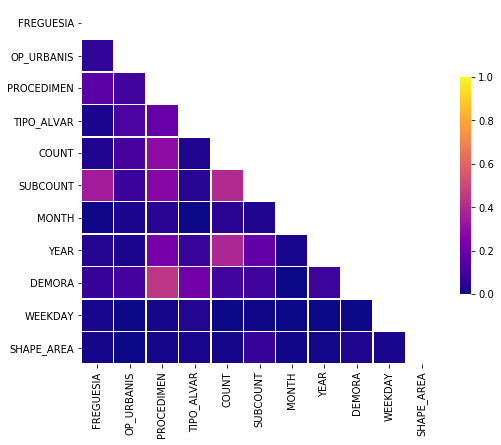

In [2386]:
# now every data is numerical I will compute the correlation matrix to remove colinearity features
corr = alvaras_ml.corr().abs()

# make a heatmap
f, ax = plt.subplots(figsize=(8, 8))

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='plasma', vmin=0, vmax=1,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=False)

In [2387]:
X = alvaras_ml.drop('DEMORA', axis=1)
y = alvaras_ml['DEMORA']

In [2388]:
# scale features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [2389]:
# make the split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [2390]:
# random forest regression
for i in range(1, 15):
    rfr = RandomForestRegressor(max_depth=i, random_state=42)
    rfr.fit(X_train, y_train)
    y_pred = rfr.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(i, mae, r2)

1 208.65740963031448 0.1929256142265089
2 201.68060188253375 0.23166946424977353
3 198.23478359052902 0.2578393101634301
4 196.2839169705654 0.27365879006706084
5 194.53273614877222 0.2895317120646175
6 192.3736490428815 0.3021904629322574
7 191.73346218954742 0.30776995979769894
8 191.56225810454723 0.310070329231778
9 191.66231866458472 0.3096349992381774
10 192.19029371280013 0.30799088257016205
11 192.08547091939482 0.3056729972436961
12 192.45391469582398 0.3012016123888249
13 192.36658831036505 0.3011664435982705
14 192.55863801808692 0.298716988195492


In [2391]:
rfr = RandomForestRegressor(max_depth=8, random_state=42)
rfr.fit(X_train, y_train)
score = rfr.score(X_train, y_train)
print('Train score:', score)
score = rfr.score(X_test, y_test)
print('Test score:', score)

y_pred_train = rfr.predict(X_train)
y_pred_test = rfr.predict(X_test)
mse_train = mean_absolute_error(y_train, y_pred_train)
mse_test = mean_absolute_error(y_test, y_pred_test)

print('mae train', mse_train)
print('mae test', mse_test)

Train score: 0.41531457971276287
Test score: 0.310070329231778
mae train 171.70257143875023
mae test 191.56225810454723


In [2392]:


# cross validate the results of the random forest regressor
cv_rfr = cross_val_score(rfr, X, y, cv=6)
print(cv_rfr)
print(cv_rfr.mean())

[0.30144249 0.32269082 0.27804827 0.27437565 0.32990217 0.30421444]
0.30177897431395784


In [2394]:
# plotting based on permit delay

In [ ]:
base = baixa_buildings.plot(figsize=(10, 10), facecolor='#adadad', edgecolor='k', alpha=1, lw=.2)
baixa_alvaras.plot(ax=base, facecolor=flatui[3], edgecolor='k', alpha=1, lw=.2)
base.axis('off');
base.margins(0)
base.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
#plt.savefig('figures/baixa_animation_end.png', dpi=100, bbox_inches='tight', pad_inches=0, transparent=False)